# Data Collection Problem Set

## Data Loading

In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException

# Load the domain list
df = pd.read_csv('domainsToInspect.csv')
domains = df['domain'].tolist()

# Load the ad block list
ad_domains = []
# with open('Adblocklist.txt', 'r') as file:
#     while True:
#         # read the second line of each two line for redundency
#         file.readline()
#         ad_domain = file.readline()
#         if not ad_domain:
#             break
#         ad_domains.append(ad_domain.strip())
with open('AdDomainlist.txt', 'r') as file:
    while True:
        # read the second line of each two line for redundency
        ad_domain = file.readline()
        if not ad_domain:
            break
        ad_domains.append(ad_domain.strip())

/var/folders/8v/r0lk2mbn2k5dgm_pdmv4_8hr0000gn/T/ipykernel_46305/2990800400.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Webdriver Initailization

In [1]:
from selenium import webdriver 
 
# Create Chromeoptions instance 
options = webdriver.ChromeOptions() 

# set header and headless mode
options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36')
options.add_argument('--headless')  

# Adding argument to disable the AutomationControlled flag 
options.add_argument("--disable-blink-features=AutomationControlled") 
 
# Exclude the collection of enable-automation switches 
options.add_experimental_option("excludeSwitches", ["enable-automation"]) 
 
# Turn-off userAutomationExtension 
options.add_experimental_option("useAutomationExtension", False) 
 
# Setting the driver path and requesting a page 
driver = webdriver.Chrome(options=options) 
 
# Changing the property of the navigator value for webdriver to undefined 
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})") 
 


## Iframe Detection

In [4]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
import time

# store iframe information to dynamc_conntent
def extract_nested_iframes(driver, dynamic_content, iframe_path='', verbose=False):
    try:
        # Wait for iframes to be present
        WebDriverWait(driver, 2).until(
            EC.presence_of_all_elements_located((By.TAG_NAME, 'iframe'))
        )
    except TimeoutException:
        if verbose:
            print("Timeout waiting for iframes to load")

    # Find all iframes at the current level
    iframes = driver.find_elements(By.TAG_NAME, 'iframe')

    for index, iframe in enumerate(iframes):
        # Construct a unique key for the iframe based on its path
        iframe_key = f'{iframe_path}iframe_{index}'

        try:
            src = iframe.get_attribute('src')
            dynamic_content[iframe_key] = src
            driver.switch_to.frame(iframe)

            # Recursively extract nested iframes
            extract_nested_iframes(driver, dynamic_content, iframe_path=f'{iframe_key}>')
            
            # Switch back to the parent frame
            driver.switch_to.parent_frame()
        except Exception as e:
            if verbose:
                print(f'Error processing {iframe_key}: {e}')
                
            # Ensure the driver is switched back to the parent frame in case of an error
            driver.switch_to.parent_frame()

# return the dynamic content of a url
def dynamic_content_extractor_nested(url):
    driver.get('http://'+url)
    time.sleep(5)
    dynamic_content = {}
    extract_nested_iframes(driver, dynamic_content=dynamic_content)
    return dynamic_content


In [5]:
import re

# check whether the url is in the ad block lst
def ad_url_check(dynamic_url):
    for ad_domain in ad_domains:
        regex_pattern = '.*' + ad_domain.replace('*', '.*').replace('.', r'\.') + '.*'
        if re.match(regex_pattern, dynamic_url):
            return True, ad_domain
    return False, None

In [6]:
from collections import Counter

# return nested counter of ad servers
def ad_url_nested_counter(url):
    dynamic_content = dynamic_content_extractor_nested(url)
    nested_counter = [Counter()]
    for k in dynamic_content:
        layer_idx = len(k.split('>'))
        if layer_idx > len(nested_counter):
            nested_counter.append(Counter())
        is_ad, ad_admin = ad_url_check(dynamic_content[k])
        if is_ad:
            nested_counter[layer_idx-1][ad_admin] += 1
    return nested_counter

# helper function for ad_server_nested_analysis
def ad_server_analysis(counter):
    uniq_ad_servers = len(counter)
    ad_servers = sum([v for k, v in counter.items()])
    return uniq_ad_servers, ad_servers

# return number of unique ad servers and total ad servers
def ad_server_nested_analysis(nested_counter):
    for i, counter in enumerate(nested_counter):
        uniq_ad_servers, ad_servers = ad_server_analysis(counter)
        if uniq_ad_servers:
            break
    return uniq_ad_servers, ad_servers
    

In [7]:
PATIENCE = 5

results = {}
failed_domains = []

# Traverse each url/domain in the list
for domain in domains:
    num_tries = 0
    while num_tries < PATIENCE:
        num_tries += 1
        try:
            nested_counter = ad_url_nested_counter(domain)
            uniq_ad_servers, ad_servers = ad_server_nested_analysis(nested_counter)
            break
        except Exception as e:
            print(f'Try {num_tries} for {domain}: error {e} found when browsing')
            uniq_ad_servers, ad_servers = 0, 0

    # Append the result to the results list
    results[domain] = (uniq_ad_servers, ad_servers)

    # if a domain is not loaded, store in list for further notice
    if num_tries == PATIENCE:
        failed_domains.append(domain)

# announce the websites where browsing is failed  
if failed_domains:
    print(f'Check those websites again: {failed_domains}')

# Write the results to a tab-separated file
with open('ad_analysis_full.tsv', 'w') as f:
    for domain, ads_number in results.items():
        uniq_ads, total_ads = ads_number
        f.write(f'{domain}\t{uniq_ads}\t{total_ads}\n')

print(f'Analysis complete. The tab-separated file is saved.')

Try 1 for india.com: error Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome-headless-shell=122.0.6261.129)
Stacktrace:
0   chromedriver                        0x0000000109c622a8 chromedriver + 4625064
1   chromedriver                        0x0000000109c59e53 chromedriver + 4591187
2   chromedriver                        0x0000000109858e6a chromedriver + 392810
3   chromedriver                        0x000000010983f1a4 chromedriver + 287140
4   chromedriver                        0x000000010983f093 chromedriver + 286867
5   chromedriver                        0x000000010985b072 chromedriver + 401522
6   chromedriver                        0x00000001098e502b chromedriver + 966699
7   chromedriver                        0x00000001098c6613 chromedriver + 841235
8   chromedriver                        0x00000001098973da chromedriver + 648154
9   chromedriver                        0x00

In [60]:
from selenium.common.exceptions import NoSuchElementException


# URL of the website
url = 'https://www.dailykos.com/'

# Open the website
driver.get(url)
# Set a timeout (in seconds)
timeout = 10
start_time = time.time()
xpath = "//*[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'donate')]"

# Loop until the button is found or the timeout is reached
while True:
    try:
        donate_button = driver.find_elements(By.XPATH, xpath)
        print("Donation button found:", len(donate_button))
        break  # Exit the loop if the button is found
    except NoSuchElementException:
        if time.time() - start_time > timeout:
            print("No donation button found within the timeout period.")
            break  # Exit the loop if the timeout is reached
        time.sleep(0.5)  # Wait a bit before trying again

Donation button found: 3


In [3]:
import pandas as pd
df_domain = pd.read_csv('ideo_domain_mbfc081123_with_weights.tsv', sep='\t')

/var/folders/8v/r0lk2mbn2k5dgm_pdmv4_8hr0000gn/T/ipykernel_59197/3110861098.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
import time
DONATE_FOUND = 1
DONATE_NOT_FOUND = 0

def check_donate(url, verbose = True):
    try:
        driver.get('https://' + url)
        print(url)
        xpath = "//*[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'donat')]"
        timeout = 5
        start_time = time.time()
        res = DONATE_NOT_FOUND
        # Loop until the button is found or the timeout is reached
        while True:
            try:
                donate_button = driver.find_element(By.XPATH, xpath)
                if verbose:
                    print("Donation button found:", donate_button.text)
                res = DONATE_FOUND
                break
            except:
                if time.time() - start_time > timeout:
                    if verbose:
                        print("No donation button found within the timeout period.")
                    break  # Exit the loop if the timeout is reached
                time.sleep(0.5)  # Wait a bit before trying again

        return res
    except:
        return 'failed'

In [9]:
df_sample = df_domain[:2]

In [7]:
check_donate('cnn.com')

cnn.com
No donation button found within the timeout period.


0

In [10]:
df_sample['donation'] = df_sample['domain'].apply(check_donate)

wikipedia.org
No donation button found within the timeout period.
msn.com
No donation button found within the timeout period.


/var/folders/8v/r0lk2mbn2k5dgm_pdmv4_8hr0000gn/T/ipykernel_59197/3987888747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['donation'] = df_sample['domain'].apply(check_donate)


In [70]:


df.head()
    

,domain,bias_rating,ave_m,cred_type
0,msn.com,left-center,743000000.0,traditional
1,cnn.com,left,535000000.0,traditional
2,dailymail.co.uk,right,484020000.0,fake
3,foxnews.com,right,391666666.0,traditional
4,newsweek.com,right-center,344790000.0,traditional


## Analysis (Histogram)

In [8]:
ads_data_df = pd.read_csv('ad_analysis.tsv', sep='\t', header=None)
ads_data_df.columns = ['domain', 'unique_ad_servers', 'total_ads']

merged_df = df.merge(ads_data_df, on='domain')
merged_df.head()

,domain,bias_rating,ave_m,cred_type,unique_ad_servers,total_ads
0,msn.com,left-center,743000000.0,traditional,1,1
1,cnn.com,left,535000000.0,traditional,6,7
2,dailymail.co.uk,right,484020000.0,fake,15,28
3,foxnews.com,right,391666666.0,traditional,9,9
4,newsweek.com,right-center,344790000.0,traditional,5,5


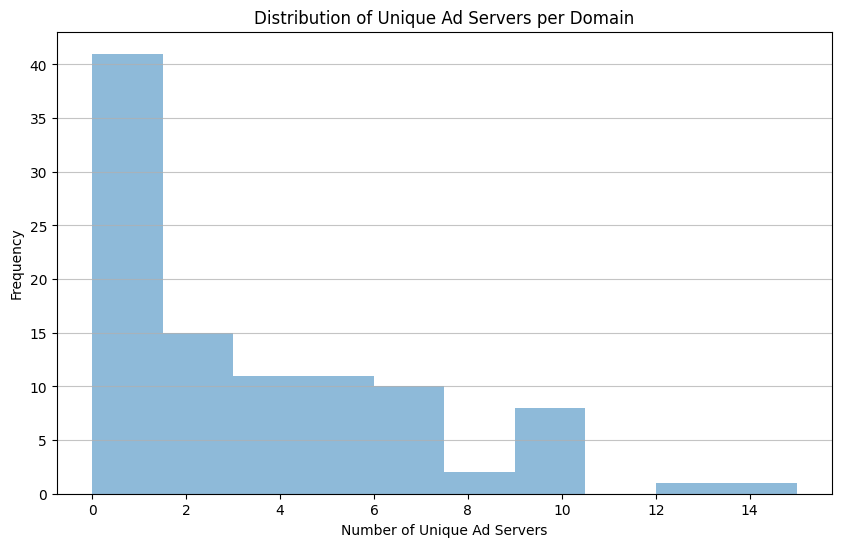

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(merged_df['unique_ad_servers'], alpha=0.5)
plt.title('Distribution of Unique Ad Servers per Domain')
plt.xlabel('Number of Unique Ad Servers')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

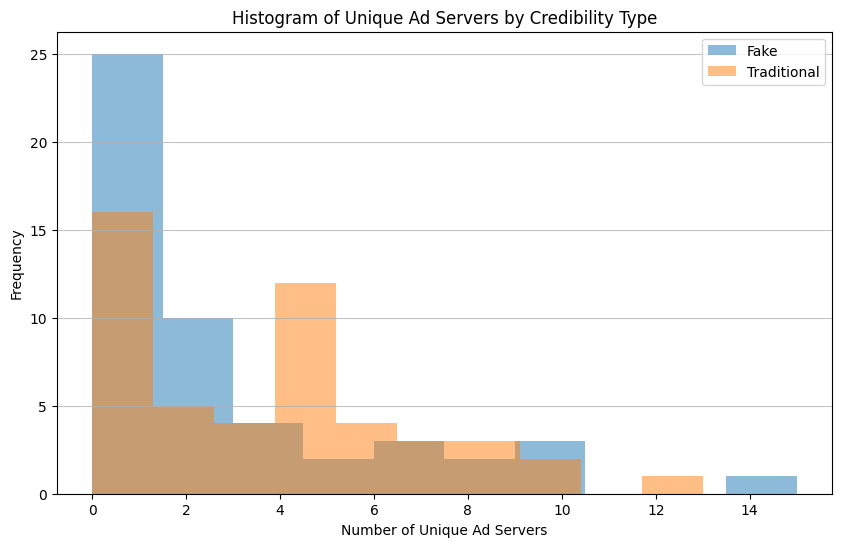

In [10]:
import numpy as np

fake_df = merged_df[merged_df['cred_type'] == 'fake']
traditional_df = merged_df[merged_df['cred_type'] == 'traditional']

plt.figure(figsize=(10, 6))

# Plot histogram for 'fake'
plt.hist(fake_df['unique_ad_servers'], alpha=0.5, label='Fake')

# Plot histogram for 'traditional'
plt.hist(traditional_df['unique_ad_servers'], alpha=0.5, label='Traditional')

plt.xlabel('Number of Unique Ad Servers')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Ad Servers by Credibility Type')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)

plt.show()